## Optiver - Trading at the Close
Predict US stocks closing movements

In this project, I was challenged to develop a model capable of predicting the closing price movements for hundreds of Nasdaq listed stocks using data from the order book and the closing auction of the stock. 

## Project Description
I have used primarily 3 models - Random Forest Regressor, LightGBM and LSTM(Long Short-Term Memory). I first analyzed various features and their relevance to the target variable, which was eventually to be predicted with atmost accuracy. In the process, I added a couple of features, dropped some to make the training as efficient as possible further helped by hyperparameter tuning. Missing numerical values were filled using median and object datatype converted to category and eventually categorical codes. Plots have been made to understand and figure out outliners, relations between some apparent important features. Special attention is given to organizing the data in a format suitable for each model, ensuring compatibility with the unique requirements of Random Forest, LSTM, and LightGBM. Amongst the 3 models, predictions on the target dataset generated from API have been done using LightGBM due to its higher accuracy during training(additionally, a larger dataset was given to it for training)



Evaluation metric: Mean absolute error

## Approach
Three different machine learning models have been employed in this project:

Random Forest:
Random Forest is a versatile ensemble learning algorithm known for its robustness and ability to handle a variety of data types. It is utilized to capture the intricate relationships within the stock data, considering features from both the order book and closing auction.

LSTM (Long Short-Term Memory):
LSTM, a type of recurrent neural network (RNN), is employed for its capacity to capture sequential dependencies in time series data. This model is adept at understanding patterns and trends over time, making it well-suited for predicting stock price movements based on historical order book and auction data.

LightGBM:
LightGBM is a gradient boosting framework designed for efficiency and scalability. It excels in handling large datasets and complex feature interactions. LightGBM is leveraged to enhance prediction accuracy by capturing non-linear relationships and intricate dependencies present in the stock data.

## Dataset Description
`stock_id` - A unique identifier for the stock. Not all stock IDs exist in every time bucket.

`date_id` - A unique identifier for the date. Date IDs are sequential & consistent across all stocks.

`imbalance_size` - The amount unmatched at the current reference price (in USD).

`imbalance_buy_sell_flag` - An indicator reflecting the direction of auction imbalance.buy-side imbalance- 1, sell-side imbalance- -1, no imbalance- 0

`reference_price`- The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.

`matched_size` - The amount that can be matched at the current reference price (in USD).

`far_price` - The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.

`near_price` - The crossing price that will maximize the number of shares matched based auction and continuous market orders.

`[bid/ask]_price` - Price of the most competitive buy/sell level in the non-auction book.

`[bid/ask]_size`- The dollar notional amount on the most competitive buy/sell level in the non-auction book.

`wap` - The weighted average price in the non-auction book.

`seconds_in_bucket` - The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.

`target` - The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index. Only provided for the train set.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

## Data Processing

Understanding data information, relations, removing outliners, filling missing values

In [2]:
df = pd.read_csv("/kaggle/input/trainset/train.csv")

In [3]:
df.head()


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [5]:
df.value_counts()

stock_id  date_id  seconds_in_bucket  imbalance_size  imbalance_buy_sell_flag  reference_price  matched_size  far_price  near_price  bid_price  bid_size   ask_price  ask_size   wap       target      time_id  row_id     
0         0        300                0.00             0                       1.000241         26670118.88   1.000241   1.000241    1.000026   19319.31   1.000241   16149.55   1.000143  -10.039806  30       0_300_0        1
133       58       420                10931140.18     -1                       1.001606         36131499.13   0.946437   0.974080    1.001577   23258.04   1.001811   24631.92   1.001691  -3.240108   3232     58_420_133     1
                   360                13835524.66     -1                       1.002690         33831895.94   0.942630   0.973670    1.002573   108531.29  1.002924   11644.66   1.002890  -9.260178   3226     58_360_133     1
                   370                12981113.14     -1                       1.001929         34173387.

In [6]:
df.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

In [7]:
df.shape

(5237980, 17)

Text(0, 0.5, 'Target')

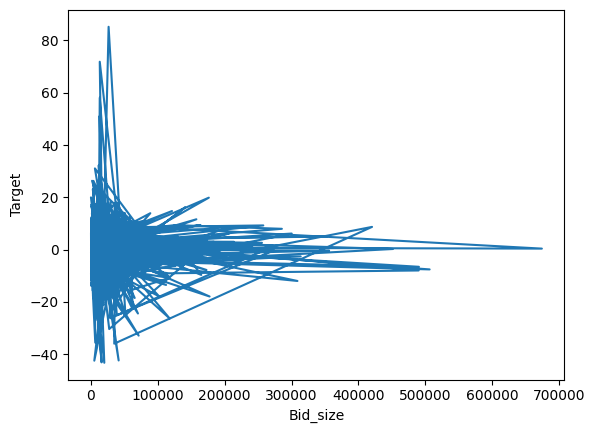

In [21]:
plt.plot(df.bid_size[:1000], df.target[:1000])
plt.xlabel("Bid_size")
plt.ylabel("Target")

In [9]:
for label,content in df.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

row_id


In [10]:
for label,content in df.items():
    if pd.api.types.is_string_dtype(content):
        df[label] = content.astype("category").cat.as_ordered()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   stock_id                 int64   
 1   date_id                  int64   
 2   seconds_in_bucket        int64   
 3   imbalance_size           float64 
 4   imbalance_buy_sell_flag  int64   
 5   reference_price          float64 
 6   matched_size             float64 
 7   far_price                float64 
 8   near_price               float64 
 9   bid_price                float64 
 10  bid_size                 float64 
 11  ask_price                float64 
 12  ask_size                 float64 
 13  wap                      float64 
 14  target                   float64 
 15  time_id                  int64   
 16  row_id                   category
dtypes: category(1), float64(11), int64(5)
memory usage: 828.3 MB


In [12]:
df.row_id.cat.categories

Index(['0_0_0', '0_0_1', '0_0_10', '0_0_100', '0_0_101', '0_0_103', '0_0_104',
       '0_0_105', '0_0_106', '0_0_107',
       ...
       '9_90_90', '9_90_91', '9_90_92', '9_90_93', '9_90_94', '9_90_95',
       '9_90_96', '9_90_97', '9_90_98', '9_90_99'],
      dtype='object', length=5237980)

In [13]:
df["imbalance_size"].isna()

0          False
1          False
2          False
3          False
4          False
           ...  
5237975    False
5237976    False
5237977    False
5237978    False
5237979    False
Name: imbalance_size, Length: 5237980, dtype: bool

## filling numeric missing values with median

In [14]:
for label,content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df[label] = content.fillna(content.median())

In [15]:
df.isna().sum()

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64

In [16]:
df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.999883,0.999889,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.999883,0.999889,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.999883,0.999889,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.999883,0.999889,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.999883,0.999889,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [17]:
for label,content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df[label] = pd.Categorical(content).codes+1

In [18]:
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.999883,0.999889,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.999883,0.999889,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.999883,0.999889,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.999883,0.999889,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.999883,0.999889,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [19]:
df.value_counts("stock_id")

stock_id
0      26455
148    26455
125    26455
126    26455
127    26455
       ...  
153    22605
199    21615
79     16500
135    15950
102    10230
Name: count, Length: 200, dtype: int64

Text(0.5, 1.0, 'stock_id vs target')

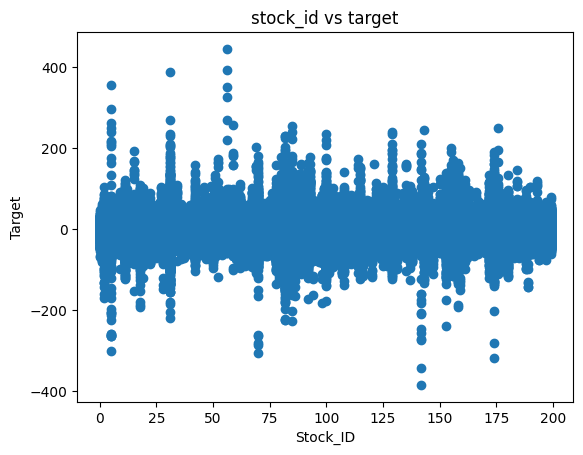

In [31]:
plt.scatter(df.stock_id,df.target)
plt.xlabel("Stock_ID")
plt.ylabel("Target")
plt.title("stock_id vs target")

Removing Outliers

In [22]:
df_mod1 = df[(df['target'] < 150) & (df['target'] > -150)]

In [23]:
len(df_mod1)

5237767

Text(0.5, 1.0, 'imbalance_size vs target')

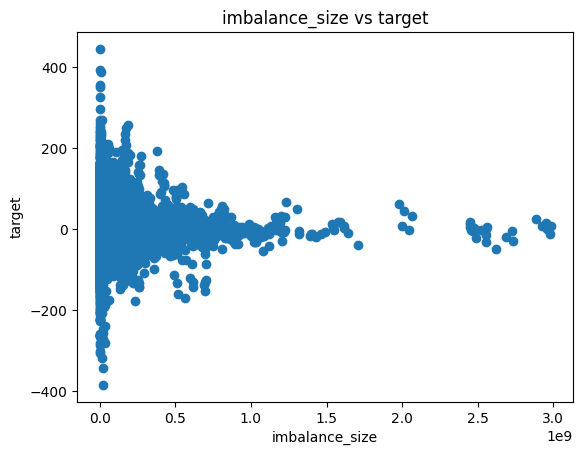

In [30]:
plt.scatter(df.imbalance_size,df.target)
plt.xlabel("imbalance_size")
plt.ylabel("target")
plt.title("imbalance_size vs target")

Text(0.5, 1.0, 'bid_size vs target')

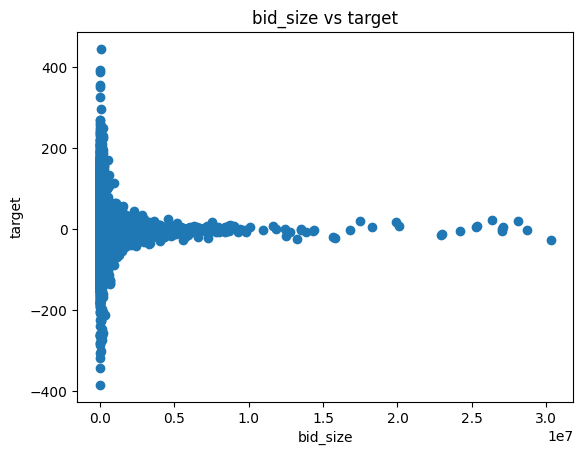

In [29]:
plt.scatter(df.bid_size,df.target)
plt.xlabel("bid_size")
plt.ylabel("target")
plt.title("bid_size vs target")

In [26]:
df_mod2 = df_mod1[(df_mod1['imbalance_size'] < 1e9)& (df_mod1['bid_size']<1e7)]

In [27]:
len(df_mod2)

5237644

Text(0.5, 1.0, 'ask_size vs target')

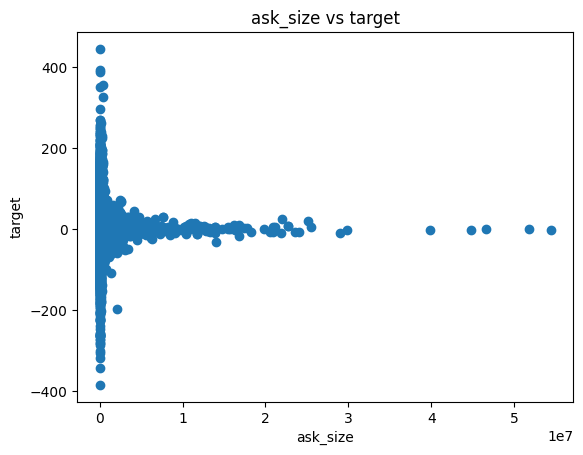

In [28]:
plt.scatter(df.ask_size,df.target)
plt.xlabel("ask_size")
plt.ylabel("target")
plt.title("ask_size vs target")

Text(0.5, 1.0, 'matched_size vs target')

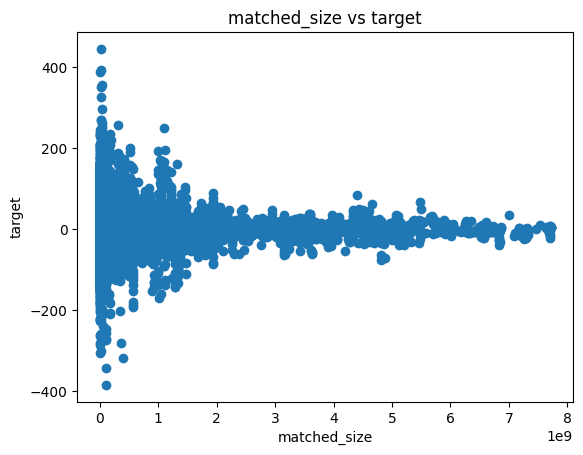

In [32]:
plt.scatter(df.matched_size,df.target)
plt.xlabel("matched_size")
plt.ylabel("target")
plt.title("matched_size vs target")

In [33]:
df_mod = df_mod2[(df_mod2["ask_size"] < 2e7)& (df_mod2["matched_size"]<7e9)]

In [34]:
df_mod.stock_id.value_counts()

stock_id
0      26455
132    26455
123    26455
124    26455
125    26455
       ...  
153    22603
199    21615
79     16500
135    15946
102    10230
Name: count, Length: 200, dtype: int64

In [35]:
len(df_mod)

5237568

In [36]:
df_mod.imbalance_buy_sell_flag.value_counts()

imbalance_buy_sell_flag
-1    2084172
 1    2021829
 0    1131567
Name: count, dtype: int64

In [16]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [37]:
import seaborn as sns

In [38]:
corr_matrix = df_mod.corr()

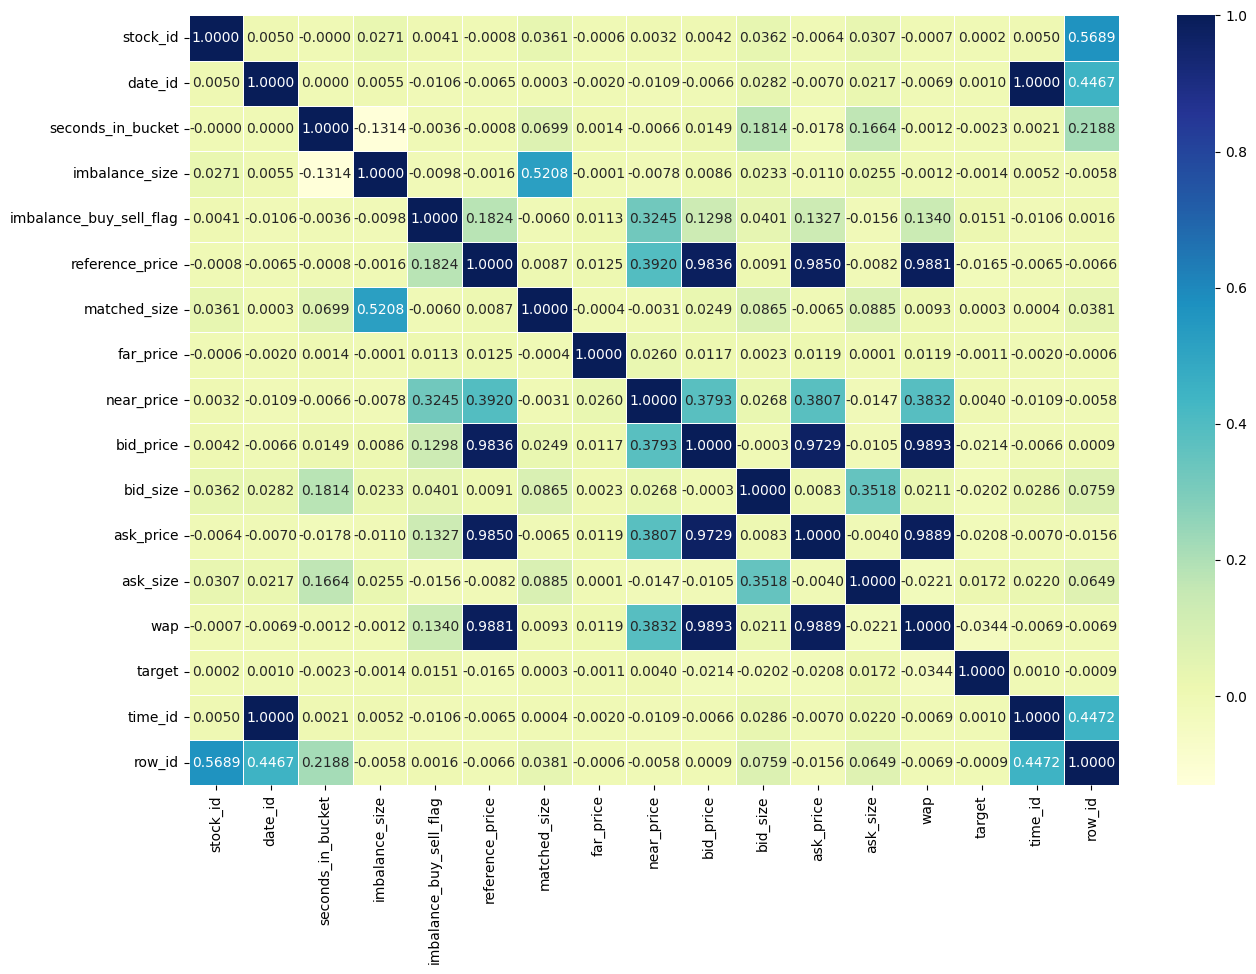

In [39]:
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".4f", 
            cmap="YlGnBu");

In [40]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5237568 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   stock_id                 int64   
 1   date_id                  int64   
 2   seconds_in_bucket        int64   
 3   imbalance_size           float64 
 4   imbalance_buy_sell_flag  int64   
 5   reference_price          float64 
 6   matched_size             float64 
 7   far_price                float64 
 8   near_price               float64 
 9   bid_price                float64 
 10  bid_size                 float64 
 11  ask_price                float64 
 12  ask_size                 float64 
 13  wap                      float64 
 14  target                   float64 
 15  time_id                  int64   
 16  row_id                   category
dtypes: category(1), float64(11), int64(5)
memory usage: 868.3 MB


In [41]:
X = df.drop("target",axis=1)
y = df["target"]

In [42]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2)

In [43]:
X_train.shape,X_val.shape,y_train.shape,y_val.shape

((4190384, 16), (1047596, 16), (4190384,), (1047596,))

In [44]:
len(X_train)

4190384

## Random Forest Regressor (model 1)

In [46]:
from sklearn.ensemble import RandomForestRegressor

In [47]:
model = RandomForestRegressor(max_samples=50000)
model.fit(X_train,y_train)

RandomForestRegressor(max_samples=50000)

In [48]:
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)

In [49]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_train,train_preds)

6.253818321430239

In [50]:
mean_absolute_error(y_val,val_preds)

6.323726934831429

In [51]:
from sklearn.model_selection import RandomizedSearchCV
rs_grid = {"n_estimators":np.arange(10,100,10),
           "max_depth":[None,3,5,10],
           "min_samples_split":np.arange(2,20,2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_samples":[30000]}

In [52]:
model_demo = RandomizedSearchCV(RandomForestRegressor(),
                                param_distributions=rs_grid,
                                n_iter=20,
                                cv=5,
                                verbose=True,
                               n_jobs=-1)

In [29]:
%%time
model_demo.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

CPU times: total: 7min 51s

Wall time: 46min 35s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_samples': [30000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [30]:
model_demo.best_params_

{'n_estimators': 90,
 'min_samples_split': 2,
 'min_samples_leaf': 11,
 'max_samples': 30000,
 'max_depth': None}

In [53]:
df_copy = df_mod.copy()

Alternate train-validation split created below

In [54]:
train_df= df_copy[df_copy['date_id']<478]
val_df = df_copy[df_copy['date_id']>=478]
X1_train = train_df.drop("target", axis=1)
y1_train = train_df["target"]
X1_val = val_df.drop("target", axis=1)
y1_val = val_df["target"]

In [58]:
model1 = RandomForestRegressor(max_samples=30000,
                              n_estimators=90,
                              min_samples_split=2,
                              min_samples_leaf=11,
                              max_depth=None,
                              verbose=1)

In [59]:
model1.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   59.5s


RandomForestRegressor(max_samples=30000, min_samples_leaf=11, n_estimators=90,
                      verbose=1)

In [60]:
train_preds = model1.predict(X_train)
val_preds = model1.predict(X_val)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   42.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    9.8s


In [ ]:
train_preds = model1.predict(X1_train)
val_preds = model1.predict(X1_val)

In [40]:
mean_absolute_error(y_train,train_preds)

6.302899089818886

In [61]:
mean_absolute_error(y_val,val_preds)

6.3173887553251955

## LightGBM (model 2)

In [24]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [62]:
import lightgbm as lgb


In [63]:
df_mod.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.999883,0.999889,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.999883,0.999889,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.999883,0.999889,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.999883,0.999889,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.999883,0.999889,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [64]:
df_mod['revealed_target'] = df_mod['target'].shift(11000)
df_mod = df_mod.drop(columns=['row_id'])
df_mod.fillna(0)

/tmp/ipykernel_42/3616919532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['revealed_target'] = df_mod['target'].shift(11000)


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,revealed_target
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.999883,0.999889,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0.000000
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.999883,0.999889,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0.000000
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.999883,0.999889,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0.000000
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.999883,0.999889,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0.000000
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.999883,0.999889,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,1.599789
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,-8.440018
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,5.149841
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,-0.249743


In [65]:
def other_features(df):
    df['hour'] = (df['seconds_in_bucket'] // 3600) % 24
    df['minute'] = (df['seconds_in_bucket'] // 60) % 60
    df['second'] = df['seconds_in_bucket'] % 60
    df['spread'] = df['ask_price'] - df['bid_price']
    df['mid_price'] = (df['ask_price'] + df['bid_price']) / 2
    df['log_return'] = df['mid_price'].pct_change().fillna(0)
    df['relative_spread'] = df['spread'] / df['mid_price']
    rolling_windows = [5, 10, 20]
    for window in rolling_windows:
        df[f'rolling_mean_{window}_imbalance_size'] = df['imbalance_size'].rolling(window=window).mean()
        df[f'rolling_mean_{window}_wap'] = df['wap'].rolling(window=window).mean()
    volatility_windows = [5, 10, 20]
    for window in volatility_windows:
        df[f'volatility_{window}'] = df['log_return'].rolling(window=window).std()
    correlation_features = ['imbalance_size', 'wap', 'matched_size', 'log_return']
    df['correlation_wap_matched_size'] = df['wap'].rolling(window=5).corr(df['matched_size'])
    #some more
    df['bid_ask_imbalance'] = abs(df['bid_size'] - df['ask_size'])
    for window in [5, 10, 20]:
        df[f'ma_{window}_imbalance_size'] = df['imbalance_size'].rolling(window=window).mean()

    # Ratio Features
    df['imbalance_matched_ratio'] = df['imbalance_size'] / (df['matched_size'] + 1e-5)

    # Weighted Price
    df['weighted_price'] = (df['bid_price'] * df['bid_size'] + df['ask_price'] * df['ask_size']) / (df['bid_size'] + df['ask_size'] + 1e-5)
    # Time-Based Features - Intraday Patterns
    df['avg_wap_same_time'] = df.groupby('seconds_in_bucket')['wap'].transform('mean')
    df['wap_deviation_same_time'] = df['wap'] - df['avg_wap_same_time']
    # Price Deviation from Reference Price
    df['price_deviation_from_ref'] = ((df['wap'] - df['reference_price']) / df['reference_price']) * 100
    
    # Bid-Ask Ratio
    df['bid_ask_ratio'] = df['bid_size'] / (df['ask_size'] + 1e-5)
    
    # Time Since Last Trade
    df['time_since_last_trade'] = df.groupby('stock_id')['seconds_in_bucket'].diff().fillna(0)
    # Distance from Bid-Ask Midpoint
    df['distance_from_midpoint'] = abs(df['wap'] - ((df['bid_price'] + df['ask_price']) / 2))

 #additions
    df['day_of_week'] = df['date_id'] % 7
    df['historical_mean_imbalance_size'] = df.groupby('stock_id')['imbalance_size'].transform(lambda x: x.rolling(window=10).mean())
    df['historical_std_imbalance_size'] = df.groupby('stock_id')['imbalance_size'].transform(lambda x: x.rolling(window=10).std())
    df['interaction_buy_sell_size'] = df['bid_size'] * df['ask_size']
    return df

In [66]:
other_features(df_mod)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,avg_wap_same_time,wap_deviation_same_time,price_deviation_from_ref,bid_ask_ratio,time_since_last_trade,distance_from_midpoint,day_of_week,historical_mean_imbalance_size,historical_std_imbalance_size,interaction_buy_sell_size
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.999883,0.999889,0.999812,...,1.000000,1.260253e-10,0.018804,7.141326,0.0,0.000081,0,NaN,NaN,5.151150e+08
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.999883,0.999889,0.999896,...,1.000000,1.260253e-10,0.010401,0.156905,0.0,0.000278,0,NaN,NaN,6.661708e+07
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.999883,0.999889,0.999403,...,1.000000,1.260253e-10,0.043919,1.998210,0.0,0.000150,0,NaN,NaN,7.209742e+08
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.999883,0.999889,0.999999,...,1.000000,1.260253e-10,-0.017097,0.004853,0.0,0.000107,0,NaN,NaN,1.113702e+09
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.999883,0.999889,0.999394,...,1.000000,1.260253e-10,0.046822,37.976364,0.0,0.000295,0,NaN,NaN,7.156373e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,...,1.000025,3.031196e-04,0.001100,0.100847,10.0,0.000047,4,2124687.056,850310.622937,1.031781e+10
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,...,1.000025,7.941196e-04,0.017589,2.196184,10.0,0.000047,4,312062.365,132837.725531,1.915570e+10
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,...,1.000025,-4.227880e-03,0.000803,0.093262,10.0,0.000039,4,772445.774,389064.925271,3.022962e+09
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,...,1.000025,-1.016880e-03,-0.020216,0.187540,10.0,0.000082,4,200179.768,422016.005515,8.415981e+10


In [67]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5237568 entries, 0 to 5237979
Data columns (total 50 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   stock_id                        int64  
 1   date_id                         int64  
 2   seconds_in_bucket               int64  
 3   imbalance_size                  float64
 4   imbalance_buy_sell_flag         int64  
 5   reference_price                 float64
 6   matched_size                    float64
 7   far_price                       float64
 8   near_price                      float64
 9   bid_price                       float64
 10  bid_size                        float64
 11  ask_price                       float64
 12  ask_size                        float64
 13  wap                             float64
 14  target                          float64
 15  time_id                         int64  
 16  revealed_target                 float64
 17  hour                            

In [68]:
df_mod.isna().sum()

stock_id                              0
date_id                               0
seconds_in_bucket                     0
imbalance_size                        0
imbalance_buy_sell_flag               0
reference_price                       0
matched_size                          0
far_price                             0
near_price                            0
bid_price                             0
bid_size                              0
ask_price                             0
ask_size                              0
wap                                   0
target                                0
time_id                               0
revealed_target                   11000
hour                                  0
minute                                0
second                                0
spread                                0
mid_price                             0
log_return                            0
relative_spread                       0
rolling_mean_5_imbalance_size         4


In [69]:
for label,content in df_mod.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df[label] = content.fillna(content.median())

In [70]:
df_copy = df_mod.copy()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5237568 entries, 0 to 5237979
Data columns (total 50 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   stock_id                        int64  
 1   date_id                         int64  
 2   seconds_in_bucket               int64  
 3   imbalance_size                  float64
 4   imbalance_buy_sell_flag         int64  
 5   reference_price                 float64
 6   matched_size                    float64
 7   far_price                       float64
 8   near_price                      float64
 9   bid_price                       float64
 10  bid_size                        float64
 11  ask_price                       float64
 12  ask_size                        float64
 13  wap                             float64
 14  target                          float64
 15  time_id                         int64  
 16  revealed_target                 float64
 17  hour                            

In [71]:
train_df= df_mod[df_mod['date_id']<478]
val_df = df_mod[df_mod['date_id']>=478]

In [72]:
X_train = train_df.drop("target", axis=1)
y_train = train_df["target"]
X_val = val_df.drop("target", axis=1)
y_val = val_df["target"]

In [73]:

from sklearn.model_selection import cross_val_score as cv
from sklearn.metrics import make_scorer,mean_absolute_error


In [74]:
len(X_train)

5204568

In [19]:
'''
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

params = {
    'boosting_type': 'gbdt',
    'num_leaves': 200,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
    # Correct parameter name for early stopping
}

model = lgb.LGBMRegressor(**params)
model.fit(X_train,y_train)
Y_pred = model.predict(X_val)
mae = mean_absolute_error(Y_pred,y_val)
print(mae)

#6.244819213649497
'''


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
6.247767687664105


Above is the results obtained when data was split as 80:20 for training and validation sets

In [21]:
from sklearn.model_selection import GridSearchCV, train_test_split

In [22]:
lgb_model = lgb.LGBMRegressor()

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_bin': [255, 511, 1023],  # Large max_bin values
    'learning_rate': [0.01, 0.05, 0.1],  # Small learning_rate
    'num_iterations': [100],  # Large num_iterations
    'num_leaves': [31, 63, 127]} # Large num_leaves

# Define GridSearchCV with Mean Absolute Error as the scoring metric
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5)

# Fit the model with the training data
grid_search.fit(X_train, y_train)


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will 

GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_bin': [255, 511, 1023], 'num_iterations': [100],
                         'num_leaves': [31, 63, 127]},
             scoring='neg_mean_absolute_error')

In [25]:
'''
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the model with the best parameters
best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = best_model.predict(X_val)

# Evaluate the model
mae = mean_absolute_error(y_val, predictions)
print("Mean Absolute Error on Test Set:", mae)

#6.2429
'''

Best Parameters: {'learning_rate': 0.1, 'max_bin': 511, 'num_iterations': 100, 'num_leaves': 127}


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Mean Absolute Error on Test Set: 6.2429388722891845


In [75]:
from sklearn.metrics import make_scorer,mean_absolute_error

In [76]:
best_params={"learning_rate":0.1,
            "max_bin":511,
            "num_iterations":100,
            "num_leaves":127}
best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = best_model.predict(X_val)

# Evaluate the model
mae = mean_absolute_error(y_val, predictions)
print("Mean Absolute Error on Test Set:", mae)


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Mean Absolute Error on Test Set: 5.257079865614332


In [77]:
df_copy.isna().sum()
df_copy=df_copy.drop(["revealed_target","rolling_mean_5_imbalance_size","rolling_mean_5_wap","rolling_mean_10_imbalance_size","rolling_mean_10_wap","rolling_mean_20_imbalance_size","rolling_mean_20_wap","volatility_5","volatility_10","volatility_20","ma_5_imbalance_size","ma_10_imbalance_size","ma_20_imbalance_size","historical_mean_imbalance_size","historical_std_imbalance_size"],axis=1)

## LSTM (Model 3)

In [79]:
len(X[X['date_id']<478])

5204980

In [80]:
df_copy = df_copy.drop("correlation_wap_matched_size",axis=1)

In [26]:
'''
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

scaler = MinMaxScaler()


# X_train = X[X['date_id']<478]
# y_train = y[:5204568]
# X_val = X[X['date_id']>=478]
# y_val = y[5204568:]


X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))


model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))  # Output layer with 1 neuron for regression
model.compile(optimizer='adam', loss='mean_absolute_error')


model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)


loss = model.evaluate(X_val, y_val, verbose=0)
print(f'Mean Absolute Error on valid Set: {loss}')


predictions = model.predict(X_val)



'''

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [33]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming 'target' is your target variable, and other columns are features
features = df_copy.drop('target', axis=1).values
target = df_copy['target'].values.reshape(-1, 1)

# Normalize features using Min-Max scaling
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Reshape the data to fit the LSTM input requirements
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))  # Output layer with 1 neuron for regression
model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Evaluate the model on the test set
loss = model.evaluate(X_val, y_val, verbose=0)
print(f'Mean Squared Error on Test Set: {loss}')

# Make predictions
predictions = model.predict(X_val)

# If you want to inverse transform the predictions to the original scale
predictions_original_scale = scaler.inverse_transform(predictions)

# You can now use predictions_original_scale for further analysis or evaluation.


Epoch 1/50
130940/130940 [==============================] - 475s 4ms/step - loss: 6.3830 - val_loss: 6.3672
Epoch 2/50
130940/130940 [==============================] - 475s 4ms/step - loss: 6.3475 - val_loss: 6.3424
Epoch 3/50
130940/130940 [==============================] - 495s 4ms/step - loss: 6.3283 - val_loss: 6.3429
Epoch 4/50
130940/130940 [==============================] - 486s 4ms/step - loss: 6.3180 - val_loss: 6.3189
Epoch 5/50
130940/130940 [==============================] - 479s 4ms/step - loss: 6.3116 - val_loss: 6.3190
Epoch 6/50
130940/130940 [==============================] - 477s 4ms/step - loss: 6.3068 - val_loss: 6.3116
Epoch 7/50
130940/130940 [==============================] - 486s 4ms/step - loss: 6.3038 - val_loss: 6.3304
Epoch 8/50
130940/130940 [==============================] - 491s 4ms/step - loss: 6.3010 - val_loss: 6.3099
Epoch 9/50
130940/130940 [==============================] - 479s 4ms/step - loss: 6.2986 - val_loss: 6.3004
Epoch 10/50
130940/130940 [=

ValueError: non-broadcastable output operand with shape (1047514,1) doesn't match the broadcast shape (1047514,33)

## API Implemetation

In [81]:
df_mod.head().T

,0,1,2,3,4
stock_id,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00
date_id,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
seconds_in_bucket,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
imbalance_size,3.180603e+06,1.666039e+05,3.028799e+05,1.191768e+07,4.475500e+05
imbalance_buy_sell_flag,1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
reference_price,9.998120e-01,9.998960e-01,9.995610e-01,1.000171e+00,9.995320e-01
matched_size,1.338028e+07,1.642214e+06,1.819368e+06,1.838975e+07,1.786061e+07
far_price,9.998830e-01,9.998830e-01,9.998830e-01,9.998830e-01,9.998830e-01
near_price,9.998890e-01,9.998890e-01,9.998890e-01,9.998890e-01,9.998890e-01
bid_price,9.998120e-01,9.998960e-01,9.994030e-01,9.999990e-01,9.993940e-01


In [82]:
import sys
sys.path.append("/kaggle/input/optiver/optiver-trading-at-the-close")

import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()
counter = 0
for (test, revealed_targets, sample_prediction) in iter_test:
    test = test.drop(columns=['row_id','currently_scored'])
    test['time_id']= test['date_id']*55 + test['seconds_in_bucket']*10
    if counter == 0:
        cache = revealed_targets 
   
    other_features(test)
    test['revealed_target']= cache['revealed_target'].iloc[counter*200:(counter+1)*200]
    test['revealed_target']= (test['revealed_target']).astype('float64')
    test = test.reset_index(drop=True)
    test = test.fillna(0)
    new_row = pd.DataFrame({
        'Iteration': counter,
        'Time_ID': test['time_id'],
        'Revealed_Target': test['revealed_target'],
        'Predicted_Target': np.nan  # Placeholder for now, update it with the actual prediction
    })

    print(cache.shape)
    print(counter)
    counter+=1
    counter= counter%55
    Y_pred = np.clip(best_model.predict(test),-64,64)
    sample_prediction['target'] = Y_pred.astype('float64')
    env.predict(sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
(11000, 6)
0
(11000, 6)
1
(11000, 6)
2
(11000, 6)
3
(11000, 6)
4
(11000, 6)
5
(11000, 6)
6
(11000, 6)
7
(11000, 6)
8
(11000, 6)
9
(11000, 6)
10
(11000, 6)
11
(11000, 6)
12
(11000, 6)
13
(11000, 6)
14
(11000, 6)
15
(11000, 6)
16
(11000, 6)
17
(11000, 6)
18
(11000, 6)
19
(11000, 6)
20
(11000, 6)
21
(11000, 6)
22
(11000, 6)
23
(11000, 6)
24
(11000, 6)
25
(11000, 6)
26
(11000, 6)
27
(11000, 6)
28
(11000, 6)
29
(11000, 6)
30
(11000, 6)
31
(11000, 6)
32
(11000, 6)
33
(11000, 6)
34
(11000, 6)
35
(11000, 6)
36
(11000, 6)
37
(11000, 6)
38
(11000, 6)
39
(11000, 6)
40
(11000, 6)
41
(11000, 6)
42
(11000, 6)
43
(11000, 6)
44
(11000, 6)
45
(11000, 6)
46
(11000, 6)
47
(11000, 6)
48
(11000, 6)
49
(11000, 6)
50
(11000, 6)
51
(11000, 6)
52
(11000, 6)
53
(11000, 6)
54
(11000, 6)
0
(11000, 6)
1
(11000, 6)
2
(11000, 6)
3
(11000, 6)
4
(11000, 6)
5
(11000, 6)
6
(11000, 6)
7
(11000, 6)
